In [1]:
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt

from arithmetic_lm.model import UniversalTransformer, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.formatting import format_line
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
ckpt_path = "../checkpoints/addition-1-9-digit-pad/ut_1steps_384embd_2head/step=15500-train_loss=0.0108-val_loss=4.6606.ckpt"

In [3]:
tokenizer = CharTokenizer()

In [4]:
# load model
ckpt = torch.load(ckpt_path, map_location="mps")
model = UniversalTransformer(
    **ckpt["hyper_parameters"]["model_hparams"], vocab_size=tokenizer.vocab_size
)
# state dict has a prefix "model." in the key names
model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
model.eval()

UniversalTransformer(
  (embedding): Embedding(100, 384, padding_idx=99)
  (coord_encoder): CoordinateEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): 

In [5]:
def eval_answer_addition(
    model,
    tokenizer,
    a: int,
    b: int,
    pad_zeros: int = 10,
    max_len: int = 11,
    verbose: bool = False,
) -> tuple[int, bool]:
    # compute real answer
    real_answer = a + b

    # prepare prompt
    prompt = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
    if verbose:
        print(f"prompt: {prompt}")
    prompt = tokenizer.encode(prompt)
    prompt = torch.tensor(prompt)

    # generate
    out_ids = generate(
        model=model,
        idx=torch.tensor(tokenizer.encode("=")),
        max_new_tokens=max_len,
        encoder_source=prompt,
        stop_token=tokenizer.encode("$")[0],
    )
    out = tokenizer.decode(out_ids[0].tolist())
    if verbose:
        print(f"output: {out}")

    # extract answer
    pred_answer = int(out.replace("$", ""))
    return out, pred_answer == real_answer

In [6]:
a = 199999
b = 4562
out, correct = eval_answer_addition(
    model, tokenizer, a, b, pad_zeros=10, max_len=12, verbose=True
)
print(f"true answer: {a+b}")
print(f"correct: {correct}")

prompt: 
$0000199999+0000004562
output: 00000204561$
true answer: 204561
correct: True


## Evaluate different number of digits in operands

Model is trained on NxN (0-padded) addition, where both operands have the same number of digits. We evaluate the model on addition of two numbers with different number of digits (still padded to same length). 

In [7]:
# matrix of accuracy
max_digits = 10
n_samples_per_cell = 100
pad_zeros = 10

accuracy_matrix = np.zeros((max_digits, max_digits))
mistakes = []

for n_a in range(1, max_digits + 1):
    for n_b in range(1, max_digits + 1):
        correct = 0
        for _ in range(n_samples_per_cell):
            # generate random numbers
            a = np.random.randint(10 ** (n_a - 1), 10**n_a)
            b = np.random.randint(10 ** (n_b - 1), 10**n_b)
            _, is_correct = eval_answer_addition(
                model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
            )
            # save mistakes
            if not is_correct:
                mistakes.append((a, b))
            correct += is_correct
        accuracy_matrix[n_a - 1, n_b - 1] = correct / n_samples_per_cell

print(accuracy_matrix)

[[1.   1.   1.   1.   1.   1.   0.99 1.   1.   0.  ]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
 [1.   1.   1.   0.99 1.   1.   1.   1.   0.98 0.  ]
 [1.   0.99 0.99 1.   0.99 0.97 0.99 0.98 0.95 0.  ]
 [1.   0.99 1.   1.   1.   1.   0.97 0.96 0.99 0.  ]
 [0.99 1.   1.   0.96 0.98 0.98 1.   0.98 0.99 0.  ]
 [0.99 1.   0.98 0.99 0.96 0.97 0.99 0.92 1.   0.  ]
 [0.99 1.   0.99 0.99 0.99 0.96 0.93 0.71 1.   0.01]
 [0.93 0.96 0.97 0.93 0.95 0.95 0.98 0.79 0.94 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.06]]


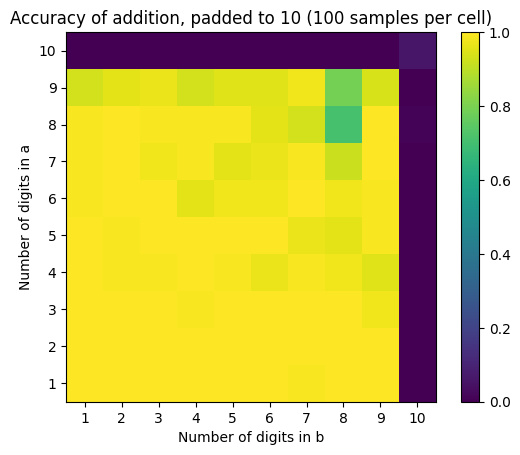

In [8]:
# plot accuracy matrix
plt.imshow(accuracy_matrix, cmap="viridis", interpolation="none")
plt.colorbar()
# set xtiks and yticks to be integers
plt.xticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.yticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.xlabel("Number of digits in b")
plt.ylabel("Number of digits in a")
plt.title(
    f"Accuracy of addition, padded to {pad_zeros} ({n_samples_per_cell} samples per cell)"
)
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [9]:
# print mistakes
for a, b in mistakes[-5:]:
    out, correct = eval_answer_addition(
        model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
    )
    if not correct:
        n_a = len(str(a))
        n_b = len(str(b))
        out_int = int(out.replace("$", ""))
        n_true_ans = len(str(a + b))
        n_pred_ans = len(str(out_int))
        print(f"{a} + {b} = {a+b}")
        print(
            " " * (n_a + n_b + (n_true_ans - n_pred_ans))
            + f"pred: {out_int} ({out}) [{n_a}+{n_b} digit]"
        )
        print()

9594660183 + 5991648758 = 15586308941
                    pred: 11586308942 (11586308942$) [10+10 digit]

7439043893 + 6698550624 = 14137594517
                    pred: 11137594517 (11137594517$) [10+10 digit]

2302038029 + 8141437216 = 10443475245
                    pred: 10443475246 (10443475246$) [10+10 digit]

6031445101 + 6321977650 = 12353422751
                    pred: 22253422751 (22253422751$) [10+10 digit]

8739680674 + 4397802016 = 13137482690
                    pred: 21137482691 (21137482691$) [10+10 digit]



## Ablate residual stream of the encoder

In [10]:
eval("model.encoder_layer.self_attn", {"model": model})

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
)

In [11]:
def predict_with_hook(
    model: torch.nn.Module,
    prompt: torch.Tensor,
    decoder_prompt: torch.Tensor,
    hook: callable,
    hook_module: str,
) -> str:
    """
    Predict next token while ablating positions in the residual stream
    at the end of encoder. ablate_positions is a list of integers
    of positions in the sequence to set to zero.
    """

    hooked_model = deepcopy(model)
    hooked_model.eval()

    # hook
    # hooked_model.encoder_layer.register_forward_hook(hook)
    eval(
        f"hooked_model.{hook_module}", {"hooked_model": hooked_model}
    ).register_forward_hook(hook)

    logits = hooked_model(source=prompt, target=decoder_prompt)[0, -1, :]
    pred_token_id, pred_token_logit = logits.argmax().item(), logits.max().item()
    pred_token_str = tokenizer.decode([pred_token_id])

    # delete hooked model
    del hooked_model

    return pred_token_str, pred_token_logit

In [12]:
a = 1239999
b = 956959
pad_zeros = 10
pad_ans_zeros = 11

prompt_str = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
print("prompt:", repr(prompt_str))
true_ans = a + b
print("true_ans:", true_ans)

# "fast-forward" to the first digit
decoder_prompt_str = "=" + "0" * (pad_ans_zeros - len(str(true_ans)))

# just before first actual digit
decoder_prompt = torch.tensor([tokenizer.encode(decoder_prompt_str)])
print(f"decoder prompt:", decoder_prompt_str)

prompt = tokenizer.encode(prompt_str)
prompt = torch.tensor([prompt])

# without ablation
logits = model(source=prompt, target=decoder_prompt)[0, -1, :]
pred_token = torch.argmax(logits).item()
pred_token_logit = logits.max().item()
print("pred_token_str:", tokenizer.decode([pred_token]), "logit:", pred_token_logit)


def mean_ablate_pos_in_res_stream(ablate_positions: list[int]):
    def hook_ablate(module, inputs, output):
        # set output to mean at ablated positions
        # output shape = [bs, seq_len, d_model]
        output[:, ablate_positions, :] = output.mean(dim=1, keepdim=True)
        return output

    return hook_ablate


# ablating digits
print("ablate digits")
for i in range(5, prompt.shape[1]):
    pred_token_ablated, logit = predict_with_hook(
        model,
        prompt,
        decoder_prompt,
        mean_ablate_pos_in_res_stream([i]),
        "encoder_layer",
    )
    # str representation of ablation, set positions to '.'
    ablated_prompt_str = prompt_str[:i] + "." + prompt_str[i + 1 :]
    print(repr(ablated_prompt_str), "predicted token:", pred_token_ablated)


# ablating multiple digits
print("ablate multiple digits")
for end in (16, 17, 18, 19):
    ablate_digits = list(range(0, end))
    pred_token_ablated, logit = predict_with_hook(
        model,
        prompt,
        decoder_prompt,
        mean_ablate_pos_in_res_stream(ablate_digits),
        "encoder_layer",
    )
    ablated_prompt_str = [
        "." if i in ablate_digits else c for i, c in enumerate(prompt_str)
    ]
    ablated_prompt_str = "".join(ablated_prompt_str)
    print(repr(ablated_prompt_str), "predicted token:", pred_token_ablated)

prompt: '\n$0001239999+0000956959'
true_ans: 2196958
decoder prompt: =0000
pred_token_str: 2 logit: 22.78687858581543
ablate digits
'\n$000.239999+0000956959' predicted token: 2
'\n$0001.39999+0000956959' predicted token: 2
'\n$00012.9999+0000956959' predicted token: 2
'\n$000123.999+0000956959' predicted token: 2
'\n$0001239.99+0000956959' predicted token: 2
'\n$00012399.9+0000956959' predicted token: 2
'\n$000123999.+0000956959' predicted token: 2
'\n$0001239999.0000956959' predicted token: 2
'\n$0001239999+.000956959' predicted token: 2
'\n$0001239999+0.00956959' predicted token: 2
'\n$0001239999+00.0956959' predicted token: 2
'\n$0001239999+000.956959' predicted token: 2
'\n$0001239999+0000.56959' predicted token: 2
'\n$0001239999+00009.6959' predicted token: 2
'\n$0001239999+000095.959' predicted token: 2
'\n$0001239999+0000956.59' predicted token: 2
'\n$0001239999+00009569.9' predicted token: 2
'\n$0001239999+000095695.' predicted token: 2
ablate multiple digits
'................

Ablating residual stream even at most positions still recovers the answer. This suggests that the model moves information about the operands to other tokens after the first self-attention layer already. Is it possible that the MLP layer in the encoder and the rest i.e. decoder are doing addition by "lookup" in the d_model space? Can we extract something interesting from embeddings after the encoder?

## Linear probe on encoder embeddings

try to predict digits in the operands from the encoder embeddings linearly, if we can, then look at what directions in the embedding space encode what digits.

In [13]:
def accuracy(logits, target):
    pred_token = torch.argmax(logits, dim=1)
    return (pred_token == target).sum().item() / target.shape[0]

In [14]:
def train_linear_probe(
    embeddings: torch.Tensor,
    targets: torch.Tensor,
    i_token: int,
    i_pred_digit: int,
    n_epochs: int = 10,
    l1_reg: float = 0.0,
    l2_reg: float = 0.0,
):
    """
    embeddings: [n_samples, seq_len, d_model]
    targets: [n_samples, n_targets]
    """
    # train linear probe to predict operands (10 + 10 = 20 digits total)
    # so, 20 independent linears from 384 (d_model) to 10 (digits)
    i_token = 0  # index of token in sequence to use for prediction
    i_pred_digit = 0  # index of digit to predict

    embeddings = embeddings[:, i_token, :]  # shape [n_samples, d_model]
    targets = targets[:, i_pred_digit]  # shape [n_samples]

    # train linear probe with L1 norm on weights
    linear_probe = torch.nn.Linear(embeddings.shape[1], 10, bias=True)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        linear_probe.parameters(), lr=0.001, weight_decay=l2_reg
    )

    loss_history = []
    acc_history = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        preds = linear_probe(embeddings.detach())
        loss = criterion(preds, targets) + l1_reg * torch.norm(linear_probe.weight, p=1)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(accuracy(preds, targets))

    return linear_probe, loss_history, acc_history

In [17]:
def compute_acc_matrix_plot(
    n_digits: int | tuple[int, int],
    n_samples: int,
    pad_zeros: int,
    pad_ans_zeros: int,
    ax: plt.Axes = None,
):
    # generate samples
    samples = []
    if isinstance(n_digits, int):
        n_digits = (n_digits, n_digits)
    for i in range(n_samples):
        a = np.random.randint(10 ** (n_digits[0] - 1), 10 ** n_digits[0])
        b = np.random.randint(10 ** (n_digits[1] - 1), 10 ** n_digits[1])
        samples.append(
            format_line(
                f"{a}+{b}={a+b}",
                pad="$",
                prepend_newline=True,
                pad_ops_zero=pad_zeros,
                pad_ans_zero=pad_ans_zeros,
            ).split("=")[
                0
            ]  # only encoder prompt
        )
    print(samples[:3])

    # get embeddings
    embeddings = []
    for sample in samples:
        prompt = tokenizer.encode(sample)
        prompt = torch.tensor([prompt])
        embeddings.append(model.encode(prompt))
    embeddings = torch.cat(embeddings)
    print("embeddings:", embeddings.shape, embeddings.dtype)

    # get operands as targets
    targets = []
    for sample in samples:
        targets.append([int(c) for c in sample if c.isdigit()])
    targets = torch.tensor(targets)  # shape = [n_samples, n_digits]
    print("targets:", targets.shape, targets.dtype)

    # separate into train and test
    n_train = int(0.8 * embeddings.shape[0])
    train_embeddings = embeddings[:n_train]
    test_embeddings = embeddings[n_train:]
    train_targets = targets[:n_train]
    test_targets = targets[n_train:]

    n_epochs = 20
    weights = np.empty(
        (train_embeddings.shape[1], 10, train_embeddings.shape[2])
    )  # linear probe weights from all tokens to all digits
    acc_matrix = np.empty((train_embeddings.shape[1], train_targets.shape[1]))
    for i_token in range(train_embeddings.shape[1]):
        for i_pred_digit in range(train_targets.shape[1]):
            linear_probe, loss_history, acc_history = train_linear_probe(
                train_embeddings,
                train_targets,
                i_token,
                i_pred_digit,
                n_epochs=n_epochs,
                l1_reg=1.0,
                l2_reg=0.0,
            )
            # compute test loss and acc
            test_preds = linear_probe(test_embeddings[:, i_token, :])
            test_targets_digit = test_targets[:, i_pred_digit]
            test_acc = accuracy(test_preds, test_targets_digit)

            # save accuracy
            acc_matrix[i_token, i_pred_digit] = test_acc
            weights[i_token, ...] = linear_probe.weight.detach().numpy()

    if ax:
        ax.imshow(acc_matrix, cmap="viridis", interpolation="none", vmin=0, vmax=1)

        # prompt tokens as yticks
        ex_a = "".join([str(i % 10) for i in range(1, n_digits[0] + 1)])
        ex_b = "".join([str(i % 10) for i in range(1, n_digits[1] + 1)])
        example_prompt = format_line(
            f"{ex_a}+{ex_b}=0",
            pad="$",
            prepend_newline=True,
            pad_ops_zero=pad_zeros,
            pad_ans_zero=pad_ans_zeros,
        ).split("=")[
            0
        ]  # only encoder prompt
        yticks = list(example_prompt)
        yticks[0] = "\\n" if yticks[0] == "\n" else yticks[0]
        ax.set_yticks(range(len(example_prompt)), list(example_prompt))

        # predicted operand digits as xticks
        xticks = [str(i) for i in example_prompt if i.isdigit()]
        ax.set_xticks(range(len(xticks)), xticks)

        # color a and b ticks
        for i in range(len(yticks)):
            if yticks[i].isdigit():
                c = (
                    "red" if i < pad_zeros + 2 else "blue"
                )  # +2 for \n$ at the beginning
                ax.yaxis.get_major_ticks()[i].label1.set_color(c)
        for i in range(len(xticks)):
            c = "red" if i < pad_zeros else "blue"
            ax.xaxis.get_major_ticks()[i].label1.set_color(c)

        ax.set_xlabel("Operand digit to predict")
        ax.set_ylabel("Embedding token")
        ax.set_title(f"\n {n_digits} digits, pading to {pad_zeros} digits")

    return acc_matrix, weights

['\n$0008895788+0001364984', '\n$0002397905+0007521010', '\n$0005761714+0005312651']
embeddings: torch.Size([1000, 23, 384]) torch.float32
targets: torch.Size([1000, 20]) torch.int64
['\n$0023428192+0029135790', '\n$0095483325+0037352908', '\n$0053742929+0080210894']
embeddings: torch.Size([1000, 23, 384]) torch.float32
targets: torch.Size([1000, 20]) torch.int64
['\n$0408635048+0742935607', '\n$0131029406+0690999989', '\n$0210362922+0830422564']
embeddings: torch.Size([1000, 23, 384]) torch.float32
targets: torch.Size([1000, 20]) torch.int64
['\n$3048882797+1339479279', '\n$6407093462+2135298501', '\n$8352163287+5181668533']
embeddings: torch.Size([1000, 23, 384]) torch.float32
targets: torch.Size([1000, 20]) torch.int64
['\n$0706976476+1257221299', '\n$0665913106+7727388151', '\n$0664915866+9066898492']
embeddings: torch.Size([1000, 23, 384]) torch.float32
targets: torch.Size([1000, 20]) torch.int64
['\n$6619751091+0292298060', '\n$5927045351+0643591417', '\n$3754443344+0679513361']


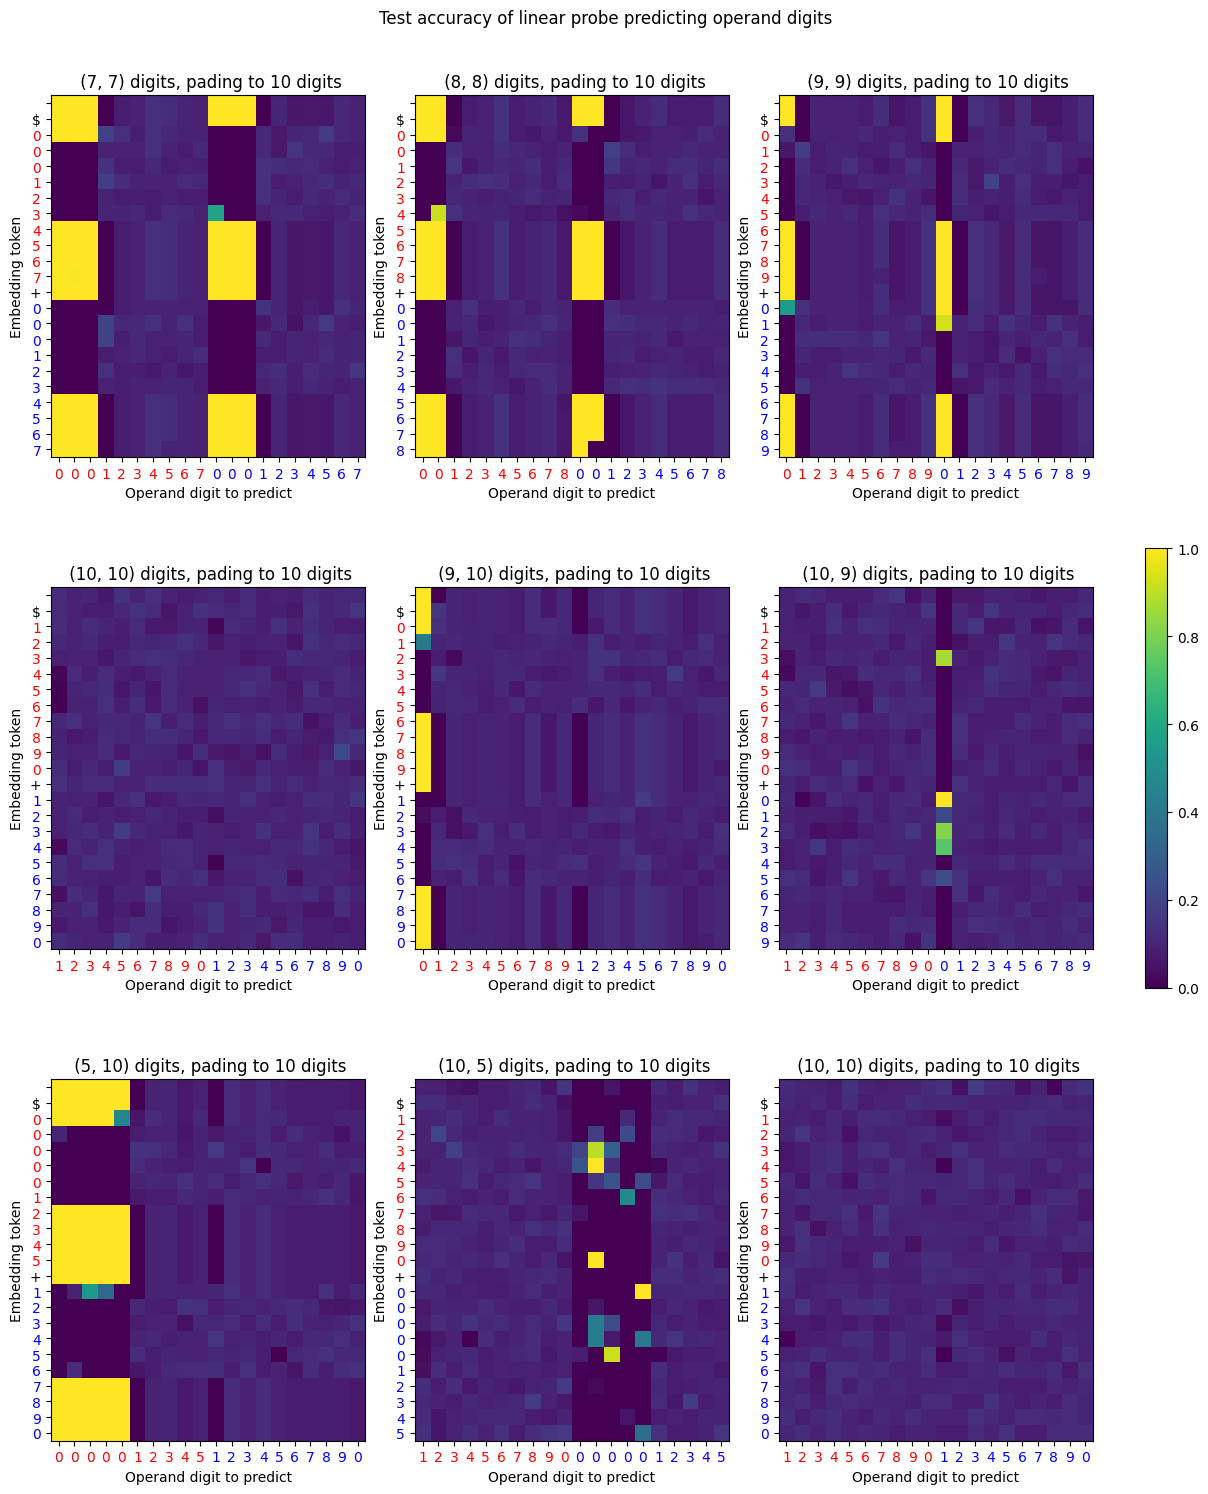

In [18]:
kwargs = dict(n_samples=1000, pad_zeros=10, pad_ans_zeros=11)
n_digits_opts = [7, 8, 9, 10, (9, 10), (10, 9), (5, 10), (10, 5), (10, 10)]

fig, axes = plt.subplots(3, 3, figsize=(12, 15), layout="constrained")
axes = axes.flatten()

for n_digits, ax in zip(n_digits_opts, axes):
    compute_acc_matrix_plot(n_digits=n_digits, **kwargs, ax=ax)

# add colorbar
fig.colorbar(axes[0].images[0], ax=axes, shrink=0.3, location="right")
fig.savefig(PLOTS_DIR / "exp8_linear_probe_operand_digits.png", dpi=90)
fig.suptitle("Test accuracy of linear probe predicting operand digits")
plt.show()